## Setup

In [1]:
import sys
sys.path.append("../projection")
from tqdm import tqdm
from moe_projection import *


def print_projection(projection_dict):
    for key, projection in projection_dict.items():
        for _, proj in projection.items():
            print(key.center(150))
            for data in proj:
                print(tabulate(data))

def print_analysis(analysis_dict, batchsize_list):
    for key, analysis in analysis_dict.items():
        for bs in batchsize_list:
            for data in analysis:
                print(key.center(100))
                print(tabulate(data[bs]))


def plot_projection(projection_dict, batchsize_list):
    plt.figure()
    for key, projection in projection_dict.items():
        if key == "decode":
            for dtype, proj in projection.items():
                for data in proj:
                    proj_list = []
                    for i in range(0, len(batchsize_list)):
                        proj_list.append(data[i][-1])
                    plt.plot(batchsize_list, proj_list, label=dtype)
    plt.xlabel("batch_size")
    plt.ylabel("throughput(tokens/sec)")
    plt.title("performance")
    plt.legend()


hidden_size = 4096
num_heads_q = 32
num_heads_kv = 8
intermediate_size = 14336
mlp_with_gate = True
num_experts = 8
num_layers = 32

dtype_list = ["bf16", "fp8"]
# in_out_token_list = [{"in": 128, "out": 128}, {"in": 1024, "out": 1024}, {"in": 1, "out": 2048}, {"in": 32000, "out": 512}]
in_out_token_list = [{"in": 128, "out": 128}]
batchsize_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

projection_dict = {"prefill": {}, "decode": {}}
analysis_dict = {"prefill": [], "decode": []}

## Prefill Projection

In [2]:
for dtype in dtype_list:
    device = type2devices[dtype]
    num_bytes = type2bytes[dtype]
    bw = device_bw_tops[device][0]
    tops = device_bw_tops[device][1]
    tops_tpc = device_bw_tops[device][2]

    # prefill
    print(
        f"projection prefill with dtype[{dtype}], device [{device}] with seq_len: {in_out_token_list} and bs {batchsize_list}...")
    projection_dict["prefill"][dtype] = []
    prefill_projection = [item_list]
    prefill_layer_analysis = dict()
    for in_out in in_out_token_list:
        for bs in tqdm(batchsize_list):
            prefill_layer_analysis[bs] = [layer_analysis_list]
            model_config = Config(batch_size=bs, seq_len_q=in_out["in"], seq_len_kv=in_out["in"], hidden_size=hidden_size, num_heads_q=num_heads_q,
                                  num_heads_kv=num_heads_kv, intermediate_size=intermediate_size, is_decoding=False, num_bytes=num_bytes,
                                  bw=bw, tops=tops, tops_tpc=tops_tpc, with_gate=mlp_with_gate, num_experts=num_experts, num_layers=num_layers)
            runtime_decoder, single_layer_items = proj_decoder(
                model_config)
            prefill_projection.append([model_config.hidden_size, model_config.num_heads_q, model_config.num_heads_kv,
                                       model_config.intermediate_size, model_config.is_decoding,
                                       model_config.num_experts, model_config.num_layers, in_out["in"], in_out["out"], dtype,
                                       bs, round(runtime_decoder, 2), round(1/runtime_decoder * model_config.batch_size, 2)])
            prefill_layer_analysis[bs].append(
                [in_out["in"], in_out["out"], dtype, bs, single_layer_items["qkvo"]["name"], round(single_layer_items["qkvo"]["#ops"]/1e9, 2),
                 round(single_layer_items["qkvo"]["#mem"]/1024/1024/1024,
                       2), round(single_layer_items["qkvo"]["tops_roofline"]/1e12, 2),
                 round(single_layer_items["qkvo"]["math_ai"], 2), single_layer_items["qkvo"]["bound"]])
            for item in single_layer_items["attn"]:
                prefill_layer_analysis[bs].append(
                    [in_out["in"], in_out["out"], dtype, bs, item["name"], round(item["#ops"]/1e9, 2), round(item["#mem"]/1024/1024/1024, 2),
                     round(item["tops_roofline"]/1e12, 2), round(item["math_ai"], 2), item["bound"]])
            for item in single_layer_items["moe"]:
                prefill_layer_analysis[bs].append(
                    [in_out["in"], in_out["out"], dtype, bs, item["name"], round(item["#ops"]/1e9, 2), round(item["#mem"]/1024/1024/1024, 2),
                     round(item["tops_roofline"]/1e12, 2), round(item["math_ai"], 2), item["bound"]])
    print("done!\n")
    # print(tabulate(prefill_projection))
    # for bs in batchsize_list:
    #     print(tabulate(prefill_layer_analysis[bs]))
    projection_dict["prefill"][dtype].append(prefill_projection)
    analysis_dict["prefill"].append(prefill_layer_analysis)

projection prefill with dtype[bf16], device [Gaudi2C_BF16] with seq_len: [{'in': 128, 'out': 128}] and bs [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]...


100%|█| 10/10 [00:00<00:0


done!

projection prefill with dtype[fp8], device [Gaudi2C_FP8] with seq_len: [{'in': 128, 'out': 128}] and bs [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]...


100%|█| 10/10 [00:00<00:0

done!



## Decode Projection

In [3]:
for dtype in dtype_list:
    device = type2devices[dtype]
    num_bytes = type2bytes[dtype]
    bw = device_bw_tops[device][0]
    tops = device_bw_tops[device][1]
    tops_tpc = device_bw_tops[device][2]

    # decode
    print(
        f"projection decoding with dtype[{dtype}], device [{device}] with seq_len: {in_out_token_list} and bs {batchsize_list}...")
    projection_dict["decode"][dtype] = []
    decoding_projection = [item_list]
    decoding_layer_analysis = dict()
    for in_out in in_out_token_list:
        for bs in tqdm(batchsize_list):
            decoding_layer_analysis[bs] = [layer_analysis_list]
            model_config = Config(batch_size=bs, seq_len_q=1, seq_len_kv=in_out["out"], hidden_size=hidden_size, num_heads_q=num_heads_q,
                                  num_heads_kv=num_heads_kv, intermediate_size=intermediate_size, is_decoding=True, num_bytes=num_bytes,
                                  bw=bw, tops=tops, tops_tpc=tops_tpc, with_gate=mlp_with_gate, num_experts=num_experts, num_layers=num_layers)
            runtime_decoder, single_layer_items = proj_decoder(
                model_config)
            decoding_projection.append([model_config.hidden_size, model_config.num_heads_q, model_config.num_heads_kv,
                                        model_config.intermediate_size, model_config.is_decoding,
                                        model_config.num_experts, model_config.num_layers, in_out["in"], in_out["out"], dtype,
                                        bs, round(runtime_decoder, 2), round(1/runtime_decoder * model_config.batch_size, 2)])
            decoding_layer_analysis[bs].append(
                [in_out["in"], in_out["out"], dtype, bs, single_layer_items["qkvo"]["name"], round(single_layer_items["qkvo"]["#ops"]/1e9, 2),
                 round(single_layer_items["qkvo"]["#mem"]/1024/1024/1024,
                       2), round(single_layer_items["qkvo"]["tops_roofline"]/1e12, 2),
                 round(single_layer_items["qkvo"]["math_ai"], 2), single_layer_items["qkvo"]["bound"]]
            )
            for item in single_layer_items["attn"]:
                decoding_layer_analysis[bs].append(
                    [in_out["in"], in_out["out"], dtype, bs, item["name"], round(item["#ops"]/1e9, 2), round(item["#mem"]/1024/1024/1024, 2),
                     round(item["tops_roofline"]/1e12, 2), round(item["math_ai"], 2), item["bound"]])
            for item in single_layer_items["moe"]:
                decoding_layer_analysis[bs].append(
                    [in_out["in"], in_out["out"], dtype, bs, item["name"], round(item["#ops"]/1e9, 2), round(item["#mem"]/1024/1024/1024, 2),
                     round(item["tops_roofline"]/1e12, 2), round(item["math_ai"], 2), item["bound"]])
    print("done!")
    # print(tabulate(decoding_projection))
    # for bs in batchsize_list:
    #     print(tabulate(decoding_layer_analysis[bs]))
    projection_dict["decode"][dtype].append(decoding_projection)
    analysis_dict["decode"].append(decoding_layer_analysis)

projection decoding with dtype[bf16], device [Gaudi2C_BF16] with seq_len: [{'in': 128, 'out': 128}] and bs [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]...


100%|█| 10/10 [00:00<00:0


done!
projection decoding with dtype[fp8], device [Gaudi2C_FP8] with seq_len: [{'in': 128, 'out': 128}] and bs [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]...


100%|█| 10/10 [00:00<00:0

done!


## Projection Result

                                                                       prefill                                                                        
----------  ---------  ----------  ---------  ----------  ----------  ---------  -----  ------  --------  ---------  -----------  -----------------------
HiddenSize  NumHeadsQ  NumHeadsKV  InterSize  IsDecoding  NumExperts  NumLayers  Input  Output  DataType  BatchSize  Latency (s)  Throughput (tokens/sec)
4096        32         8           14336      False       8           32         128    128     bf16      1          0.04         22.48
4096        32         8           14336      False       8           32         128    128     bf16      2          0.09         23.42
4096        32         8           14336      False       8           32         128    128     bf16      4          0.17         23.42
4096        32         8           14336      False       8           32         128    128     bf16      8          0.34         23.

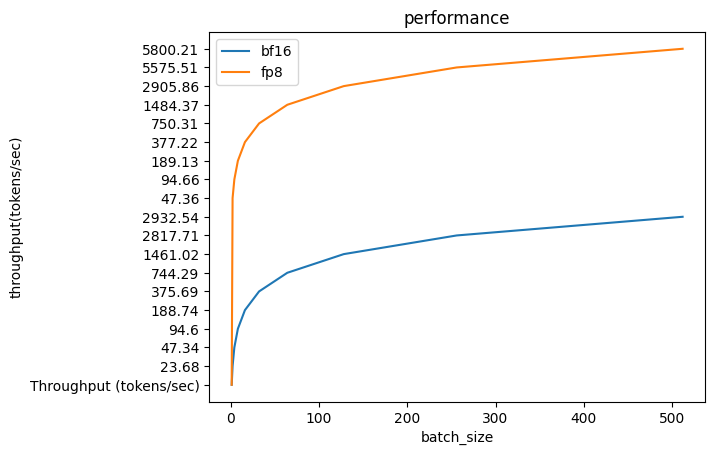

In [4]:
print_projection(projection_dict)
plot_projection(projection_dict, batchsize_list)

## Analysis Result

In [5]:
print_analysis(analysis_dict, batchsize_list)

                                              prefill                                               
-----  ------  --------  ---------  ------------  ----------  ----------  --------------  ------  -------
Input  Output  DataType  BatchSize  LayerName     NumOps(e9)  Memory(GB)  TopsRF(TFlops)  AI      Bound
128    128     bf16      1          qkvo_proj     17.18       0.13        269.85          120.47  memory
128    128     bf16      1          q@k_T         0.13        0.0         127.43          56.89   memory
128    128     bf16      1          softmax       0.34        0.0         22.0            160.0   compute
128    128     bf16      1          score@v       0.13        0.0         127.43          56.89   memory
128    128     bf16      1          mlp_up(w1)    15.03       0.11        275.64          123.06  memory
128    128     bf16      1          mlp_down(w2)  15.03       0.11        275.64          123.06  memory
128    128     bf16      1          mlp_gate(w3)  15.03   